In [2]:
!pip install pandasql

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26799 sha256=2abea210cb30ed59cbe3f26ab7fd5e5a005202a54dcf9c5b67998e7294784b3b
  Stored in directory: c:\users\soura\appdata\local\pip\cache\wheels\b4\d0\8c\a6b366870bf041849cd96e03b71641e082f8d6456269b603b7
Successfully built pandasql


  DEPRECATION: Building 'pandasql' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'pandasql'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from pandasql import sqldf
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

In [5]:
# Data loading and initial cleaning


df = pd.read_csv('r_dataisbeautiful_posts.csv')

# Dropping rows where title is missing
df.dropna(subset=['title'], inplace=True)

# Dropping columns that are not useful or have too many missing values
df.drop(['id', 'author_flair_text', 'awarders', 'created_utc', 'full_link'], axis=1, inplace=True)

# Impute (fill) missing values
df['total_awards_received'].fillna(0, inplace=True)
df['removed_by'].fillna('Not Deleted', inplace=True)


C:\Users\soura\AppData\Local\Temp\ipykernel_33692\2519763542.py:4: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('r_dataisbeautiful_posts.csv')
C:\Users\soura\AppData\Local\Temp\ipykernel_33692\2519763542.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['total_awards_received'].fillna(0, inplace=True)
C:\Users\soura\AppData\Local\Temp\ipykernel_33692\2519763542.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series t

In [6]:
df.head()

,title,score,author,removed_by,total_awards_received,num_comments,over_18
0,[OC] The World’s Forests Mapped,1,vividmaps,Not Deleted,0.0,1,False
1,[OC] Airbnb presence mapped in Barcelona (BCN)...,1,JonnieNeptune,Not Deleted,0.0,0,False
2,A marketplace for open streaming data sources,1,DangerMouse289,automod_filtered,0.0,0,False
3,[OC] Black Owner-Occupied Housing,1,SocialExplorerInc,Not Deleted,0.0,1,False
4,[OC] My monthly average steps in 2020. Quarant...,1,ahmedgelemli,Not Deleted,0.0,0,False


In [7]:
df.shape

(193090, 7)

In [8]:
df.describe()

,score,total_awards_received,num_comments
count,193090.000000,193090.000000,193090.000000
mean,180.262090,0.001626,26.374639
std,1946.312184,0.126901,206.887457
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000
50%,1.000000,0.000000,1.000000
75%,4.000000,0.000000,4.000000
max,116226.000000,30.000000,18801.000000


In [9]:
df.isna().sum()

title                    0
score                    0
author                   0
removed_by               0
total_awards_received    0
num_comments             0
over_18                  0
dtype: int64

In [10]:
# Feature Engineering : Creating the target variable

# Create the binary target variable 'is_removed'
# 1 if 'removed_by' is anything other than 'Not Deleted', 0 otherwise.
df['is_removed'] = df['removed_by'].apply(lambda x: 1 if x != 'Not Deleted' else 0)

# Now drop the original 'removed_by' and 'over_18' columns
df.drop(['removed_by', 'over_18'], axis=1, inplace=True)


In [11]:
# EDA using SQL

# Setup for pandasql
pysqldf = lambda q: sqldf(q, globals())

print("--- EDA with PandaSQL ---")

# a) GROUP BY and HAVING: Find authors with an average score greater than 1000
q1 = """
SELECT
    author,
    AVG(score) AS average_score,
    COUNT(title) AS post_count
FROM
    df
WHERE
    author != '[deleted]'
GROUP BY
    author
HAVING
    AVG(score) > 1000
ORDER BY
    average_score DESC
LIMIT 10;
"""
print("\nTop 10 Authors with Average Score > 1000:")
print(pysqldf(q1))

# b) CASE Statement: Categorize posts by score
q2 = """
SELECT
    CASE
        WHEN score = 0 THEN 'Zero Score'
        WHEN score > 0 AND score <= 100 THEN 'Low Score'
        WHEN score > 100 AND score <= 1000 THEN 'Medium Score'
        ELSE 'High Score'
    END AS score_category,
    COUNT(*) AS post_count,
    AVG(num_comments) as avg_comments
FROM
    df
GROUP BY
    score_category
ORDER BY
    avg_comments DESC;
"""
print("\nPost Counts and Avg Comments by Score Category:")
print(pysqldf(q2))

# c) Window Function and CTE: Rank posts by score for each author
q3 = """
WITH RankedPosts AS (
    SELECT
        author,
        title,
        score,
        ROW_NUMBER() OVER(PARTITION BY author ORDER BY score DESC) as rank_num
    FROM
        df
    WHERE
        author in ('NeilFGD', 'PieChartPirate')
)
SELECT
    author,
    title,
    score
FROM
    RankedPosts
WHERE
    rank_num <= 3;
"""
print("\nTop 3 Posts by Score for Selected Authors:")
print(pysqldf(q3))

--- EDA with PandaSQL ---

Top 10 Authors with Average Score > 1000:
               author  average_score  post_count
0      MOSTEPICPLAYER       116226.0           1
1             comp615        60503.0           1
2              Kewpit        53351.0           1
3           superpaow        53269.0           1
4             R1zzles        51149.0           1
5            matholio        48005.0           1
6           maxandron        47647.0           1
7         dinoignacio        45874.0           1
8        Soproudofyou        45194.0           1
9  Critical_Thinking_        42455.0           1

Post Counts and Avg Comments by Score Category:
  score_category  post_count  avg_comments
0     High Score        3681    803.170334
1   Medium Score        5491     67.614642
2      Low Score      167704     10.291937
3     Zero Score       16214      2.401505

Top 3 Posts by Score for Selected Authors:
           author                                              title  score
0  PieCh

## Correlation analysis and Visualization


--- Correlation and Visualization ---


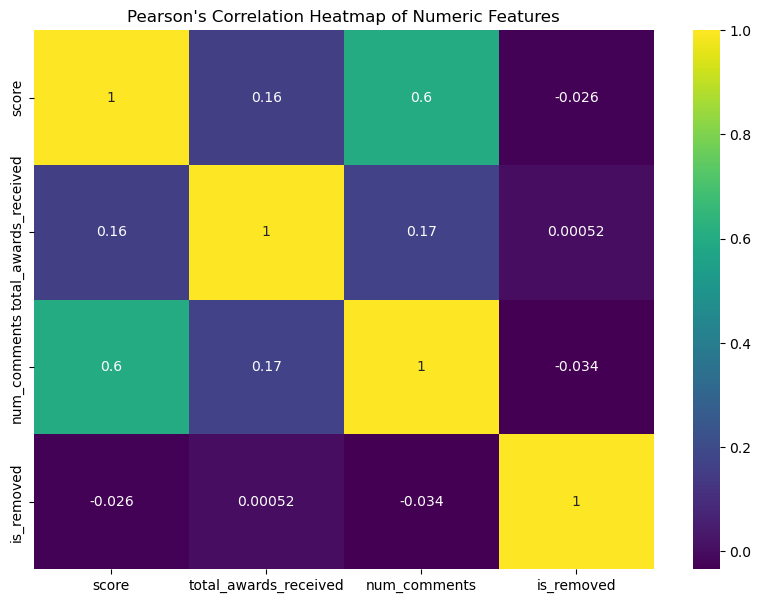

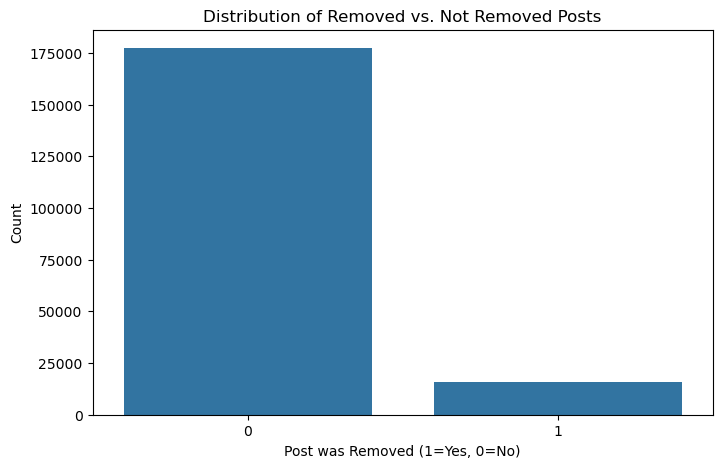

Target variable distribution:
 is_removed
0    0.918768
1    0.081232
Name: proportion, dtype: float64


In [12]:
print("\n--- Correlation and Visualization ---")

# a) Pearson's Correlation Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='viridis')
plt.title("Pearson's Correlation Heatmap of Numeric Features")
plt.show()

# b) Target Variable Distribution Chart
plt.figure(figsize=(8, 5))
sns.countplot(x='is_removed', data=df)
plt.title('Distribution of Removed vs. Not Removed Posts')
plt.xlabel('Post was Removed (1=Yes, 0=No)')
plt.ylabel('Count')
plt.show()
print("Target variable distribution:\n", df['is_removed'].value_counts(normalize=True))


## Text Preprocessing (Stemming, Stop-Words, TF-IDF)


--- Text Preprocessing ---


C:\Users\soura\AppData\Local\Temp\ipykernel_33692\1053650147.py:13: DeprecationWarning: 'count' is passed as positional argument
  text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A) # Remove punctuation and numbers


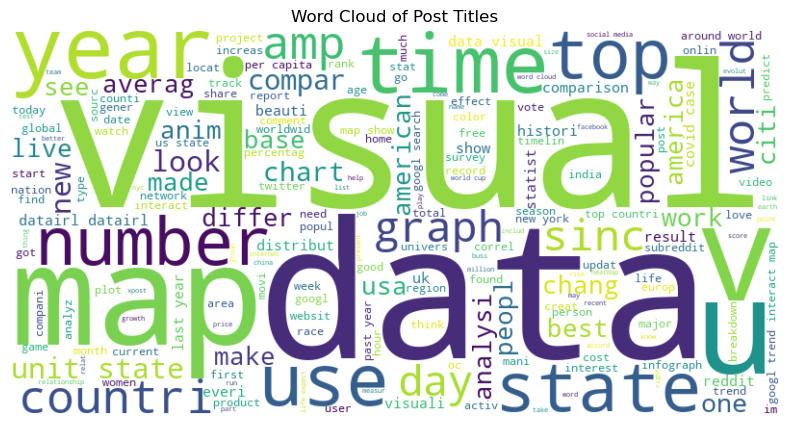

Shape of TF-IDF matrix: (193090, 5000)
Shape of target variable: (193090,)


In [13]:
print("\n--- Text Preprocessing ---")

# Download necessary NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Preprocessing Function
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'\[.*?\]', '', text) # Remove tags like [OC]
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A) # Remove punctuation and numbers
    text = text.lower() # Lowercase
    tokens = word_tokenize(text) # Tokenize
    # Remove stopwords and apply stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(stemmed_tokens)

# Apply preprocessing to the 'title' column
df['cleaned_title'] = df['title'].apply(preprocess_text)

# d) Word Cloud (on cleaned titles)
text_for_wordcloud = " ".join(df['cleaned_title'])
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text_for_wordcloud)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Word Cloud of Post Titles")
plt.axis("off")
plt.show()

# e) TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000) # Use top 5000 features
X_text = vectorizer.fit_transform(df['cleaned_title'])
y = df['is_removed']

print("Shape of TF-IDF matrix:", X_text.shape)
print("Shape of target variable:", y.shape)


## Model Training and Evaluation

In [14]:
print("\n--- Model Training and Evaluation ---")

# a) Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42, stratify=y)

# b) Train Decision Tree Model
# Using class_weight='balanced' to handle the imbalanced dataset
dt_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred_dt = dt_classifier.predict(X_test)

# c) Train Random Forest Model
rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

# d) Evaluate Models and Achieve F1-Score
print("\n--- Decision Tree Results ---")
print(classification_report(y_test, y_pred_dt))
print(f"Decision Tree F1-Score: {f1_score(y_test, y_pred_dt):.2f}")

print("\n--- Random Forest Results ---")
print(classification_report(y_test, y_pred_rf))
print(f"Random Forest F1-Score: {f1_score(y_test, y_pred_rf):.2f}")

print("\nProject completion successful!")


--- Model Training and Evaluation ---

--- Decision Tree Results ---
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     35481
           1       0.25      0.39      0.31      3137

    accuracy                           0.86     38618
   macro avg       0.60      0.65      0.61     38618
weighted avg       0.89      0.86      0.87     38618

Decision Tree F1-Score: 0.31

--- Random Forest Results ---
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     35481
           1       0.46      0.26      0.33      3137

    accuracy                           0.91     38618
   macro avg       0.70      0.62      0.64     38618
weighted avg       0.90      0.91      0.90     38618

Random Forest F1-Score: 0.33

Project completion successful!
